In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
    
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
cwd = os.getcwd()
store_TG_TN_TX_RR_HU_PP = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds_multi = xr.open_dataset(store_TG_TN_TX_RR_HU_PP, engine='zarr', chunks={})

store_SURFACE_DOWNWELLING = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-surface-downwelling.zarr'
ds_rad = xr.open_dataset(store_SURFACE_DOWNWELLING, engine='zarr', chunks={})

In [4]:
def check_data_info():
    print("time serial:")
    print("*" * 40)
    print(f"multi_time from: {ds_multi.time.min().values} to {ds_multi.time.max().values}")
    print(f"radation_time from: {ds_rad.time.min().values} to {ds_rad.time.max().values}")
    
    print("spatial:")
    print("*" * 40)
    print(f"multi_latitude from: {ds_multi.latitude.min().values:.2f} to {ds_multi.latitude.max().values:.2f}")
    print(f"multi_longitude from: {ds_multi.longitude.min().values:.2f} to {ds_multi.longitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.latitude.min().values:.2f} to {ds_rad.latitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.longitude.min().values:.2f} to {ds_rad.longitude.max().values:.2f}")

check_data_info()

time serial:
****************************************
multi_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
radation_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
spatial:
****************************************
multi_latitude from: 25.05 to 71.45
multi_longitude from: -24.95 to 45.45
radiation_latitude from: 25.05 to 70.95
radiation_latitude from: -24.95 to 44.95


In [5]:
def normalize_data(data, mean=None, std=None):
    if mean is None:
        mean = np.nanmean(data, axis=(0, 2, 3), keepdims=True)
        std = np.nanstd(data, axis=(0, 2, 3), keepdims=True)
        std = np.where(std == 0, 1.0, std)
    
    normalized = (data - mean) / std
    
    normalized = np.nan_to_num(normalized, nan=0.0)
    
    return normalized, mean, std

In [6]:
def create_lstm_sequences(X, y, seq_len=10):

    n_time, n_features, n_lat, n_lon = X.shape
    input_dim = n_features * n_lat * n_lon
    output_dim = n_lat * n_lon

    X_seq = []
    y_seq = []
    for i in range(seq_len, n_time):

        x_window = X[i-seq_len:i]         
        x_window_flat = x_window.reshape(seq_len, -1)
        y_flat = y[i].reshape(-1)

        X_seq.append(x_window_flat)
        y_seq.append(y_flat)

    X_seq = np.stack(X_seq, axis=0).astype(np.float32)
    y_seq = np.stack(y_seq, axis=0).astype(np.float32)

    return X_seq, y_seq


In [7]:
#time from 1950 to 2020
#latitude from 25 to 69(X)
#longitude form -24 to 44(X)
#train=80%(20% in val_dataset) test=20% 


#since the datas on the ocean range are NaN, So I choose Hungary(latitude from 45 to 49 and longitude from 16 to 23) to train 



def prepare_lstm_data(ds_multi, ds_rad, 
                    lat_range=(45, 49), 
                    lon_range=(16, 23),
                    train_ratio=0.8,
                    val_ratio=0.8,
                    time_sample_freq=1,
                    batch_size=32,
                    seq_len=30):


    ds_multi = ds_multi.sortby("time")
    ds_rad   = ds_rad.sortby("time")

    _, idx_multi = np.unique(ds_multi.time.values, return_index=True)
    ds_multi = ds_multi.isel(time=idx_multi)

    _, idx_rad = np.unique(ds_rad.time.values, return_index=True)
    ds_rad = ds_rad.isel(time=idx_rad)

    common_time = np.intersect1d(ds_multi.time.values, ds_rad.time.values)
    ds_multi = ds_multi.sel(time=common_time)
    ds_rad   = ds_rad.sel(time=common_time)

    ds_multi = ds_multi.sel(time=slice("1950-01-01", "2020-12-31"))
    ds_rad   = ds_rad.sel(time=slice("1950-01-01", "2020-12-31"))

    print(f"   spatial range: latitude {lat_range}, longitude {lon_range}")
    print(f"   time sample frequency: {time_sample_freq}")


    bbox_multi = ds_multi.where(
        (ds_multi.latitude >= lat_range[0]) & 
        (ds_multi.latitude <= lat_range[1]) &
        (ds_multi.longitude >= lon_range[0]) &
        (ds_multi.longitude <= lon_range[1]),
        drop=True
    )
    
    bbox_rad = ds_rad.where(
        (ds_rad.latitude >= lat_range[0]) & 
        (ds_rad.latitude <= lat_range[1]) &
        (ds_rad.longitude >= lon_range[0]) &
        (ds_rad.longitude <= lon_range[1]),
        drop=True
    )


    bbox_multi = bbox_multi.interpolate_na(dim="latitude", method="linear")
    bbox_multi = bbox_multi.interpolate_na(dim="longitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="latitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="longitude", method="linear")


    bbox_multi_sampleed = bbox_multi.isel(time=slice(0, None, time_sample_freq))
    bbox_rad_sampleed   = bbox_rad.isel(time=slice(0, None, time_sample_freq))
    
    n_time = len(bbox_multi_sampleed.time)
    n_train = int(n_time * train_ratio)

    print('*'*50)
    print(f"   number of time samples: {n_time}")

    train_multi = bbox_multi_sampleed.isel(time=slice(0, n_train))
    test_multi  = bbox_multi_sampleed.isel(time=slice(n_train, None))
    train_rad   = bbox_rad_sampleed.isel(time=slice(0, n_train))
    test_rad    = bbox_rad_sampleed.isel(time=slice(n_train, None))

    print('*'*50)
    print(f"   train samples: {len(train_multi.time)}")
    print(f"   test samples: {len(test_multi.time)}")

    print('*'*50)
    print('predictors: rr pp hu qq')
    print('predictand: tg')
    

    X_train_rr = train_multi['rr'].values.astype(np.float32)
    X_train_pp = train_multi['pp'].values.astype(np.float32)
    X_train_hu = train_multi['hu'].values.astype(np.float32)
    X_train_qq = train_rad['qq'].values.astype(np.float32)
    y_train    = train_multi['tg'].values.astype(np.float32)
    
    X_test_rr = test_multi['rr'].values.astype(np.float32)
    X_test_pp = test_multi['pp'].values.astype(np.float32)
    X_test_hu = test_multi['hu'].values.astype(np.float32)
    X_test_qq = test_rad['qq'].values.astype(np.float32)
    y_test    = test_multi['tg'].values.astype(np.float32)

    y_train = np.nan_to_num(y_train, nan=0.0)
    y_test  = np.nan_to_num(y_test,  nan=0.0)

    X_train_lstm = np.stack([X_train_rr, X_train_pp, X_train_hu, X_train_qq], axis=1)  # (time, features, lat, lon)
    X_test_lstm  = np.stack([X_test_rr,  X_test_pp,  X_test_hu,  X_test_qq ], axis=1)


    X_train_norm, train_mean, train_std = normalize_data(X_train_lstm)
    X_test_norm,  _,          _         = normalize_data(X_test_lstm, train_mean, train_std)


    def create_lstm_sequences(X, y, seq_len=10):
        n_time, n_features, n_lat, n_lon = X.shape
        input_dim = n_features * n_lat * n_lon
        output_dim = n_lat * n_lon
        X_seq, y_seq = [], []
        for i in range(seq_len, n_time):
            X_seq.append(X[i-seq_len:i].reshape(seq_len, -1))
            y_seq.append(y[i].reshape(-1))
        return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

    X_train_seq, y_train_seq = create_lstm_sequences(X_train_norm, y_train, seq_len)
    X_test_seq,  y_test_seq  = create_lstm_sequences(X_test_norm,  y_test,  seq_len)

    print(f"   LSTM sequence shapes -> X_train: {X_train_seq.shape}, y_train: {y_train_seq.shape}")


    X_train_tensor = torch.FloatTensor(X_train_seq)
    y_train_tensor = torch.FloatTensor(y_train_seq)
    X_test_tensor  = torch.FloatTensor(X_test_seq)
    y_test_tensor  = torch.FloatTensor(y_test_seq)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)


    train_size = int(val_ratio * len(train_dataset))
    val_size   = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=True)
    val_loader   = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


    n_lat = train_multi.latitude.shape[0]
    n_lon = train_multi.longitude.shape[0]
    input_dim = X_train_seq.shape[-1]
    output_dim = y_train_seq.shape[-1]

    data_dict = {
        'train_loader': train_loader,
        'val_loader':   val_loader,
        'test_loader':  test_loader,
        'input_shape': (seq_len, input_dim),
        'output_shape': (output_dim,),
        'time_train': train_multi.time.values[seq_len:],
        'time_test':  test_multi.time.values[seq_len:],
        'normalization': {
            'mean': train_mean,
            'std': train_std
        },
        'spatial_info': {
            'latitude': train_multi.latitude.values,
            'longitude': train_multi.longitude.values,
            'n_lat': n_lat,
            'n_lon': n_lon
        },
        'seq_len': seq_len
    }

    print('FINISH')
    return data_dict


In [8]:
data_dict = prepare_lstm_data(ds_multi, ds_rad)

   spatial range: latitude (45, 49), longitude (16, 23)
   time sample frequency: 1
**************************************************
   number of time samples: 25922
**************************************************
   train samples: 20737
   test samples: 5185
**************************************************
predictors: rr pp hu qq
predictand: tg
   LSTM sequence shapes -> X_train: (20707, 30, 11200), y_train: (20707, 2800)
FINISH


In [9]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [10]:
train_loader = data_dict['train_loader']
val_loader   = data_dict['val_loader']
test_loader  = data_dict['test_loader']

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=None, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [12]:
n_lat = len(data_dict['spatial_info']['latitude'])
n_lon = len(data_dict['spatial_info']['longitude'])
input_dim = 4 * n_lat * n_lon
output_dim = n_lat * n_lon

model_lstm = LSTMModel(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=2,
    output_dim=output_dim,
    dropout=0.2
)


In [13]:
def pytorch_train(model, optimizer, criterion, device, num_epochs, train_loader, val_loader):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
       # training
       model.train()
       train_loss = 0.0
       for batch_X, batch_y in train_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           # forward pass
           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           # backward pass
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
    
        # validation
       model.eval()
       val_loss = 0.0
       with torch.no_grad():
           for batch_X, batch_y in val_loader:
               batch_X = batch_X.to(device)
               batch_y = batch_y.to(device)
               
               outputs = model(batch_X)
               loss = criterion(outputs, batch_y)
               val_loss += loss.item()
       
       train_loss /= len(train_loader)
       val_loss /= len(val_loader)
    
       train_losses.append(train_loss)
       val_losses.append(val_loss)
       
       print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
       
       if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f'Early stopping at epoch {epoch+1}')
               break
   
    return train_losses, val_losses


In [14]:
model_lstm.to(device)

LSTMModel(
  (lstm): LSTM(11200, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2800, bias=True)
)

In [15]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_losses, val_losses = pytorch_train(
    model=model_lstm,
    train_loader=data_dict['train_loader'],
    val_loader=data_dict['val_loader'],
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs
)


Epoch 1/100, Train Loss: 32.2721, Val Loss: 11.1412
Epoch 2/100, Train Loss: 10.7048, Val Loss: 9.3299
Epoch 3/100, Train Loss: 9.6100, Val Loss: 8.8016
Epoch 4/100, Train Loss: 9.1365, Val Loss: 8.3797
Epoch 5/100, Train Loss: 8.3740, Val Loss: 7.6579
Epoch 6/100, Train Loss: 7.9053, Val Loss: 7.5146
Epoch 7/100, Train Loss: 7.6616, Val Loss: 7.3213
Epoch 8/100, Train Loss: 7.3587, Val Loss: 6.8174
Epoch 9/100, Train Loss: 6.9978, Val Loss: 7.1248
Epoch 10/100, Train Loss: 6.7940, Val Loss: 6.4191
Epoch 11/100, Train Loss: 6.6392, Val Loss: 6.7490
Epoch 12/100, Train Loss: 6.4947, Val Loss: 6.4896
Epoch 13/100, Train Loss: 6.3646, Val Loss: 6.2484
Epoch 14/100, Train Loss: 6.1498, Val Loss: 6.2271
Epoch 15/100, Train Loss: 6.0764, Val Loss: 6.0086
Epoch 16/100, Train Loss: 5.8858, Val Loss: 6.1777
Epoch 17/100, Train Loss: 5.8405, Val Loss: 6.1829
Epoch 18/100, Train Loss: 5.6057, Val Loss: 5.6650
Epoch 19/100, Train Loss: 5.4357, Val Loss: 5.4385
Epoch 20/100, Train Loss: 5.3026, Val

In [16]:
def plot_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

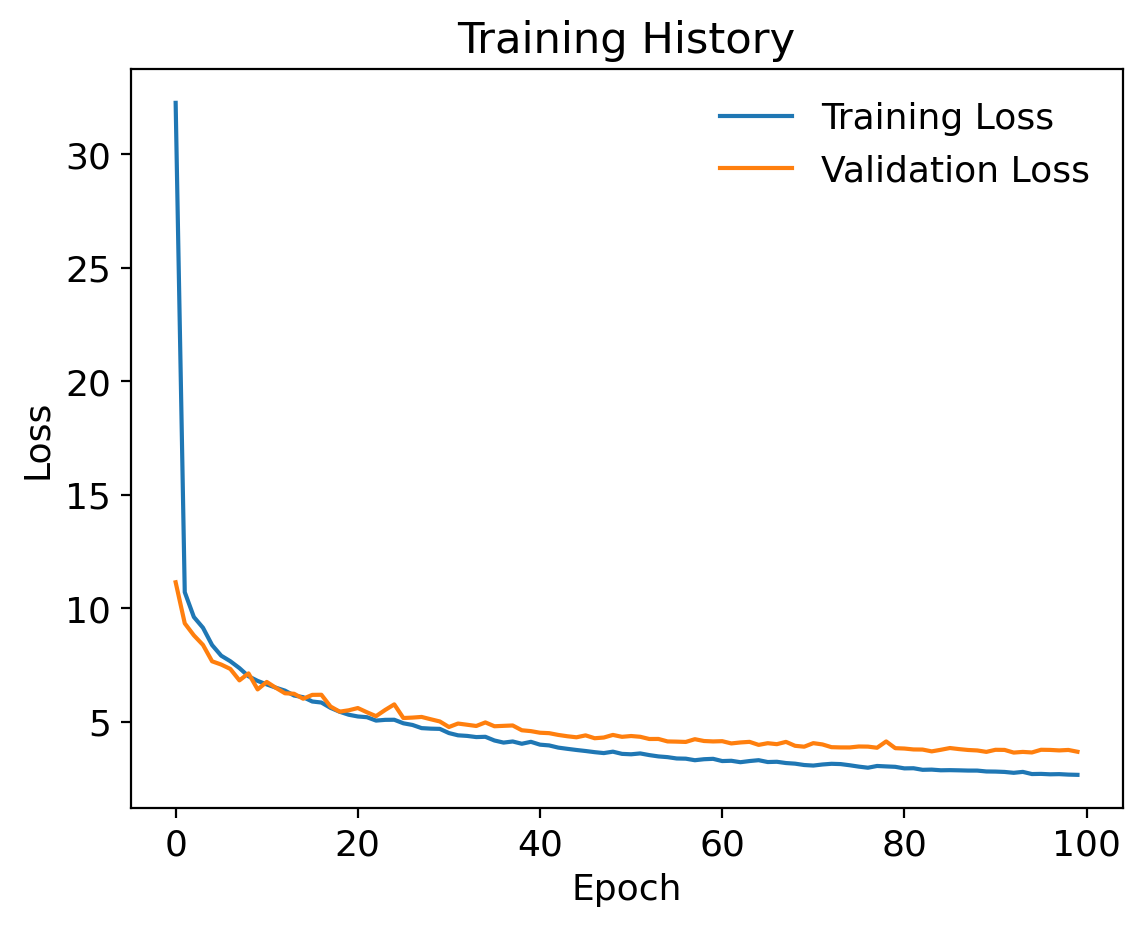

In [17]:
plot_history(train_losses, val_losses)

In [18]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [19]:
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)

In [20]:
torch.save(model_lstm.state_dict(), os.path.join(model_path, 'LSTM_model_weights.pth'))

In [21]:
#make new model instance for evaluation(best parctice)
model_eval = LSTMModel(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=2,
    output_dim=output_dim,
    dropout=0.2
)

# reload the saved model weights
state_dict = torch.load(os.path.join(model_path,'LSTM_model_weights.pth'), weights_only=True)
model_eval.load_state_dict(state_dict)


<All keys matched successfully>

In [22]:
model_eval.to(device).eval()

predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:      
        batch_X = batch_X.to(device)
        outputs = model_eval(batch_X)
        predictions.append(outputs.cpu().numpy())

y_test_pre = np.concatenate(predictions, axis=0)


lat = len(data_dict['spatial_info']['latitude'])
lon = len(data_dict['spatial_info']['longitude'])
y_test_pre = y_test_pre.reshape(-1, lat, lon)


y_test_pre = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude']
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test_pre)
    )
)


In [23]:
y_test_tensor = data_dict['test_loader'].dataset.tensors[1]
y_test = y_test_tensor.numpy()


lat = len(data_dict['spatial_info']['latitude'])
lon = len(data_dict['spatial_info']['longitude'])
y_test = y_test.reshape(-1, lat, lon)


y_test_xr = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude'],
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test)
    )
)


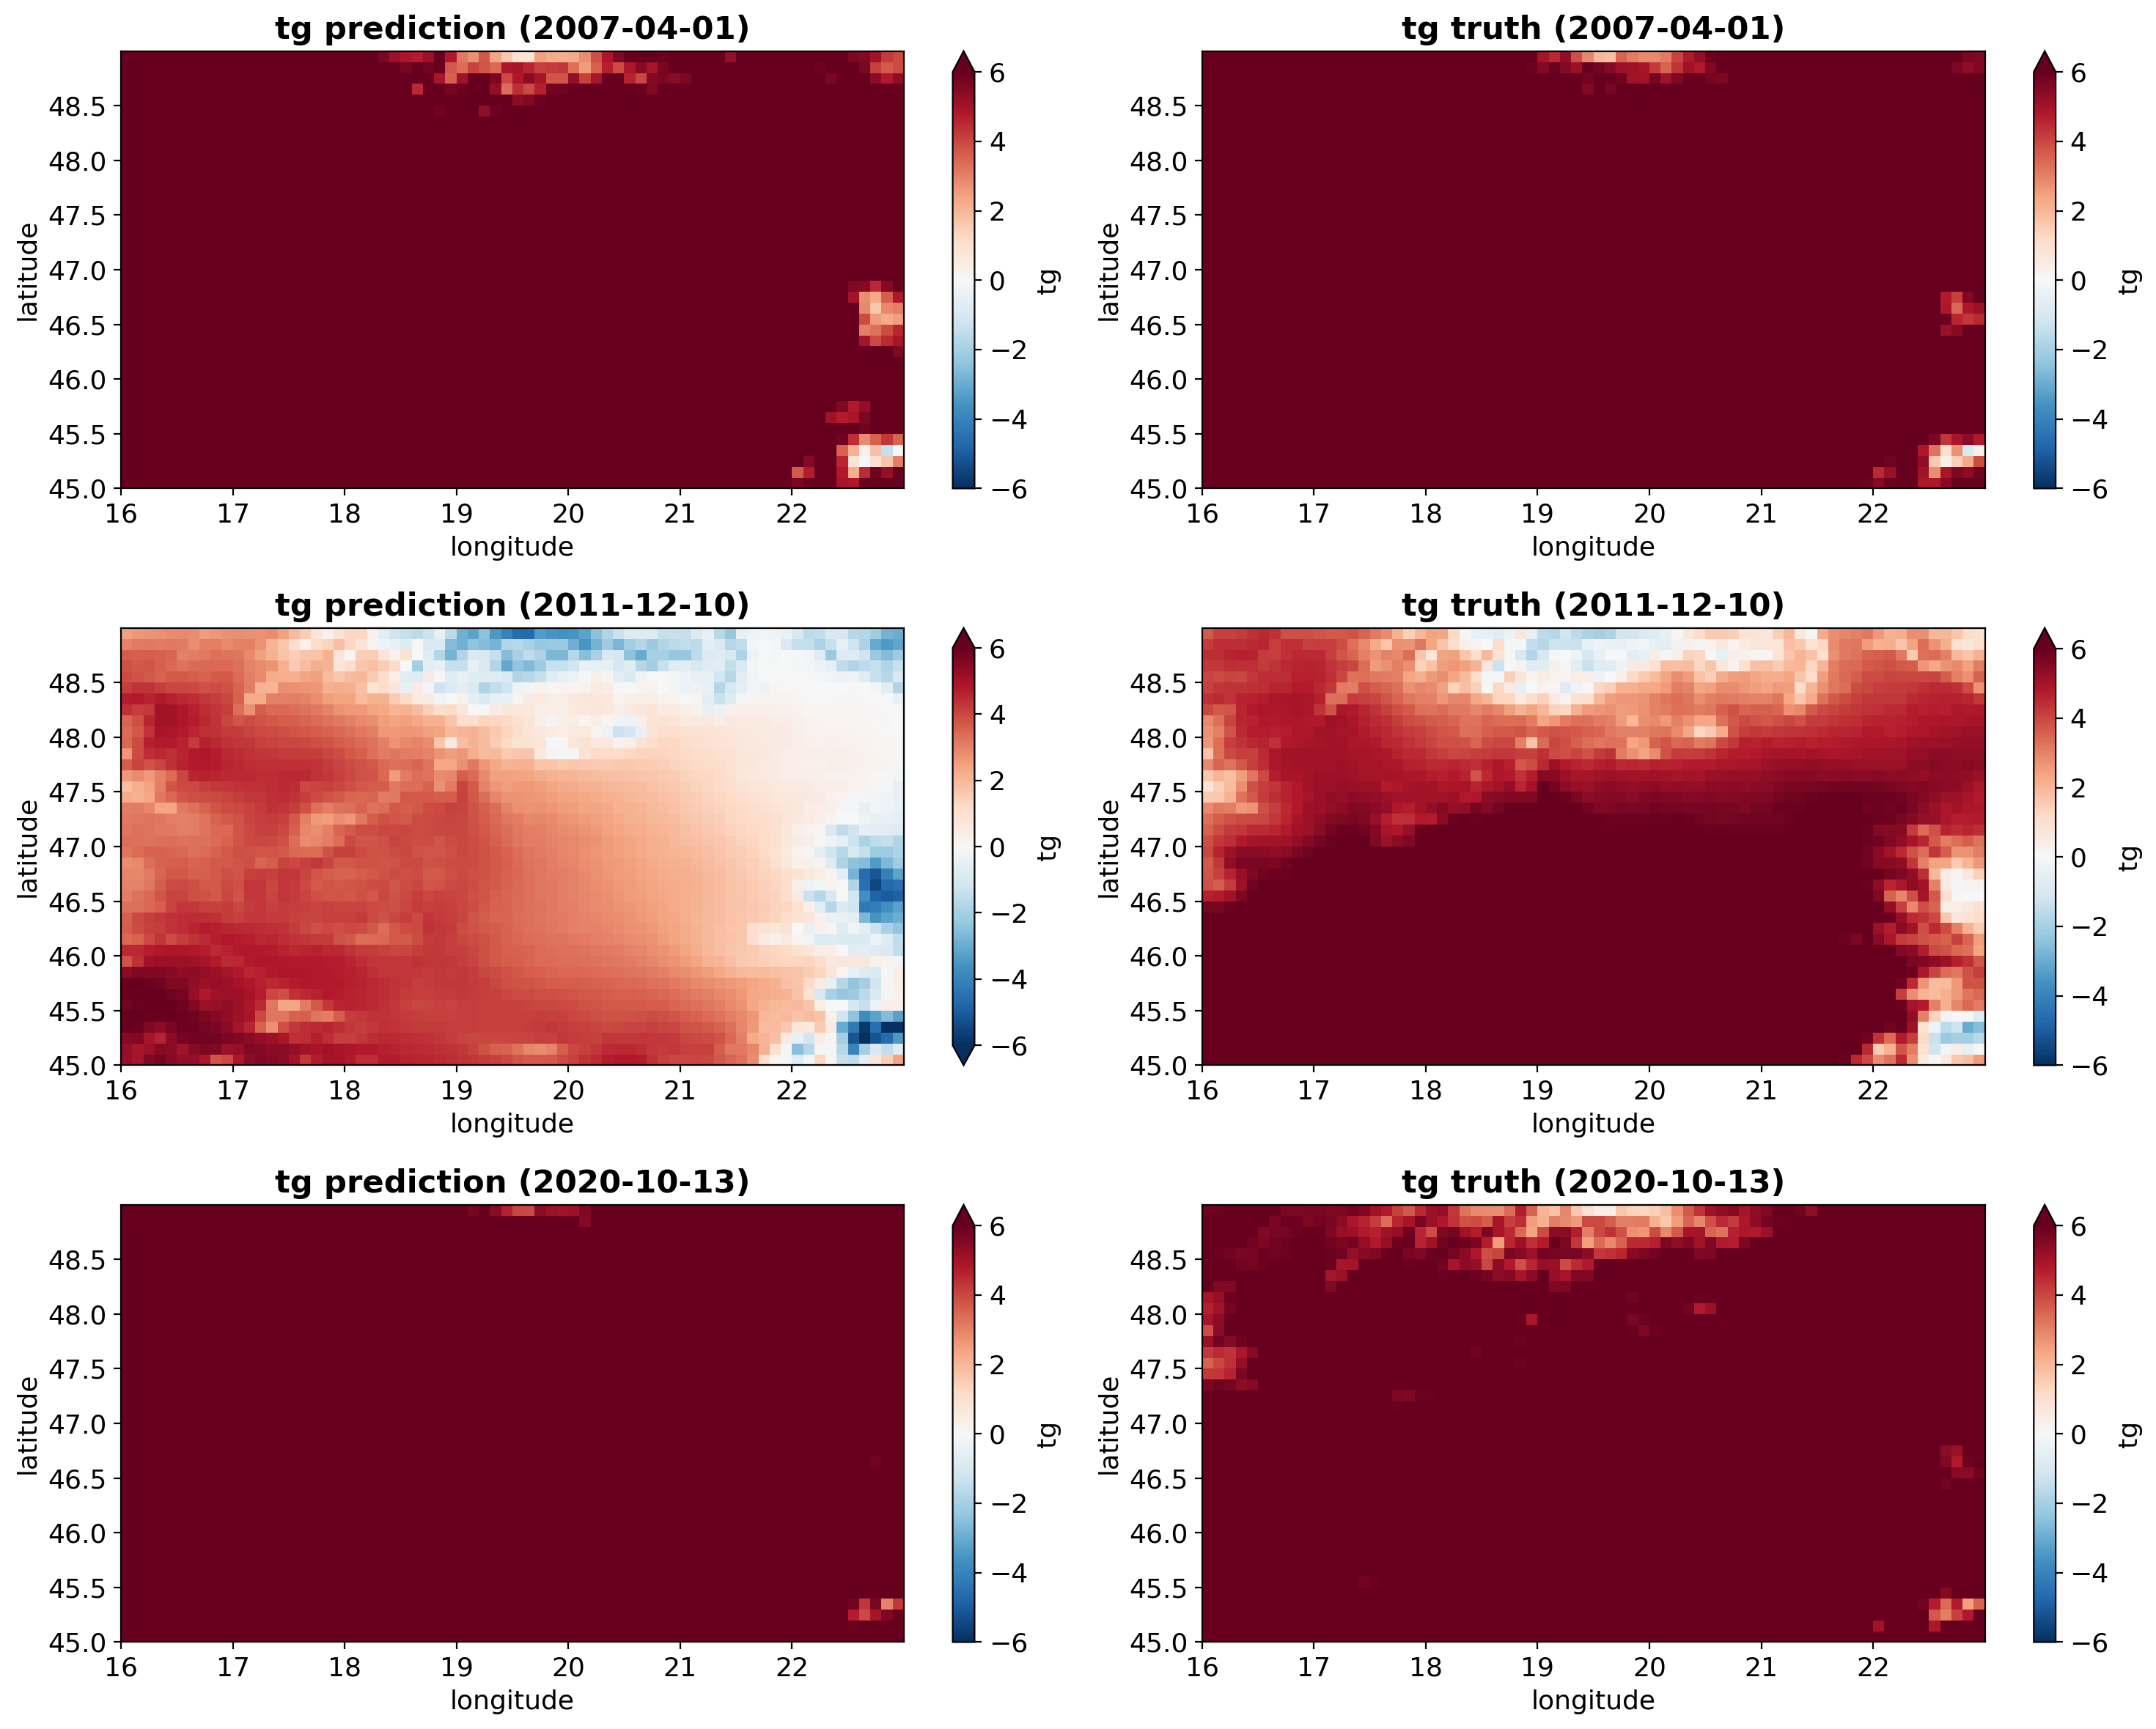

In [24]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

yrs = [
    '2007-04-01T00:00:00.000000000',
    '2011-12-10T00:00:00.000000000',
    '2020-10-13T00:00:00.000000000',
]

vmin, vmax = -6, 6
cmap = 'RdBu_r'

y_test_pre.tg.sel(time=yrs[0]).plot(ax=axes[0, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[0]).plot(ax=axes[0, 1], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_pre.tg.sel(time=yrs[1]).plot(ax=axes[1, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[1]).plot(ax=axes[1, 1], vmin=vmin, vmax=vmax, cmap=cmap)


y_test_pre.tg.sel(time=yrs[2]).plot(ax=axes[2, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[2]).plot(ax=axes[2, 1], vmin=vmin, vmax=vmax, cmap=cmap)


for i, ax in enumerate(axes.flat):
    
    if i % 2 == 0:
        ax.set_title(f'tg prediction ({yrs[i//2][:10]})', fontweight='bold')
    
    else:
        ax.set_title(f'tg truth ({yrs[i//2][:10]})', fontweight='bold')

plt.tight_layout()
plt.show()


Text(0, 0.5, 'temperature (°C)')

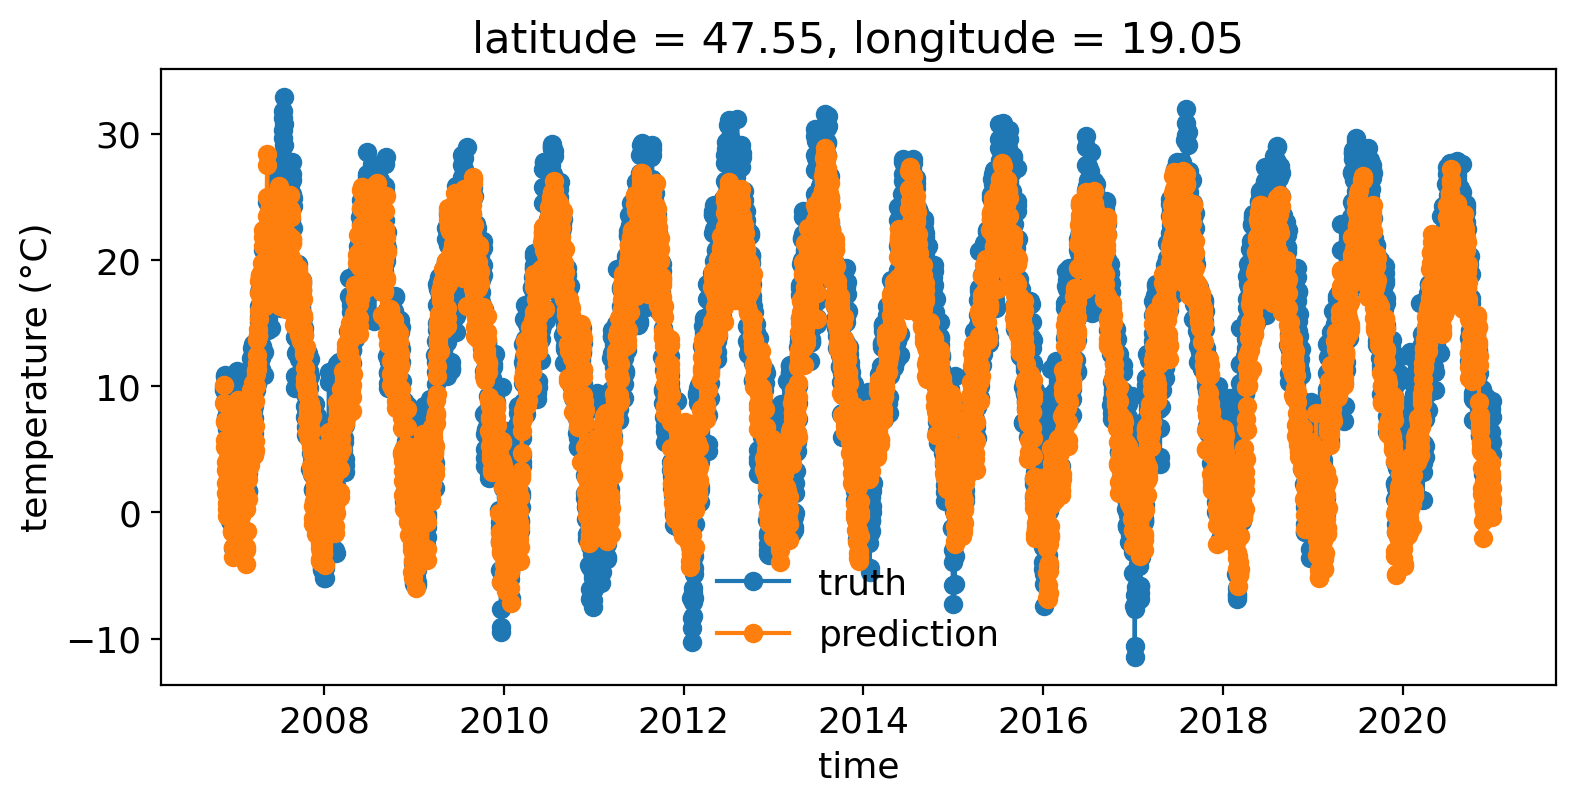

In [25]:
#Budapest
lat = 47.5
lon = 19.0

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

In [26]:
# combine truth and prediction arrays into a dataframe
bud_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.values
bud_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.values

df_bud_test = pd.DataFrame()
df_bud_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_bud_test["truth"] = bud_test_xr
df_bud_test["prediction"] = bud_test_pre
print(df_bud_test.head(10))

# summary statistics of the dataframe
df_bud_test.describe()

        time      truth  prediction
0 2006-11-21   9.700000    8.676387
1 2006-11-22   9.980000   10.109250
2 2006-11-23  10.780000    7.220653
3 2006-11-24   8.880000    5.718123
4 2006-11-25  10.150000    5.226127
5 2006-11-26  10.870000    7.168735
6 2006-11-27  10.599999    3.996975
7 2006-11-28  10.150000    3.381662
8 2006-11-29   7.600000    2.312119
9 2006-11-30   8.480000    1.569287


,time,truth,prediction
count,5155,5155.000000,5155.000000
mean,2013-12-11 00:00:00,12.964850,11.898955
min,2006-11-21 00:00:00,-11.500000,-7.213363
25%,2010-06-01 12:00:00,6.020000,4.332047
50%,2013-12-11 00:00:00,13.270000,12.728434
75%,2017-06-21 12:00:00,20.025000,19.276312
max,2020-12-31 00:00:00,32.919998,28.878105
std,NaN,8.631923,8.337224


In [27]:
def area_mean_std_plot(X,label,color,ax,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tg_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tg_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tg_mean+tg_std,tg_mean-tg_std,facecolor=color,alpha=0.2)


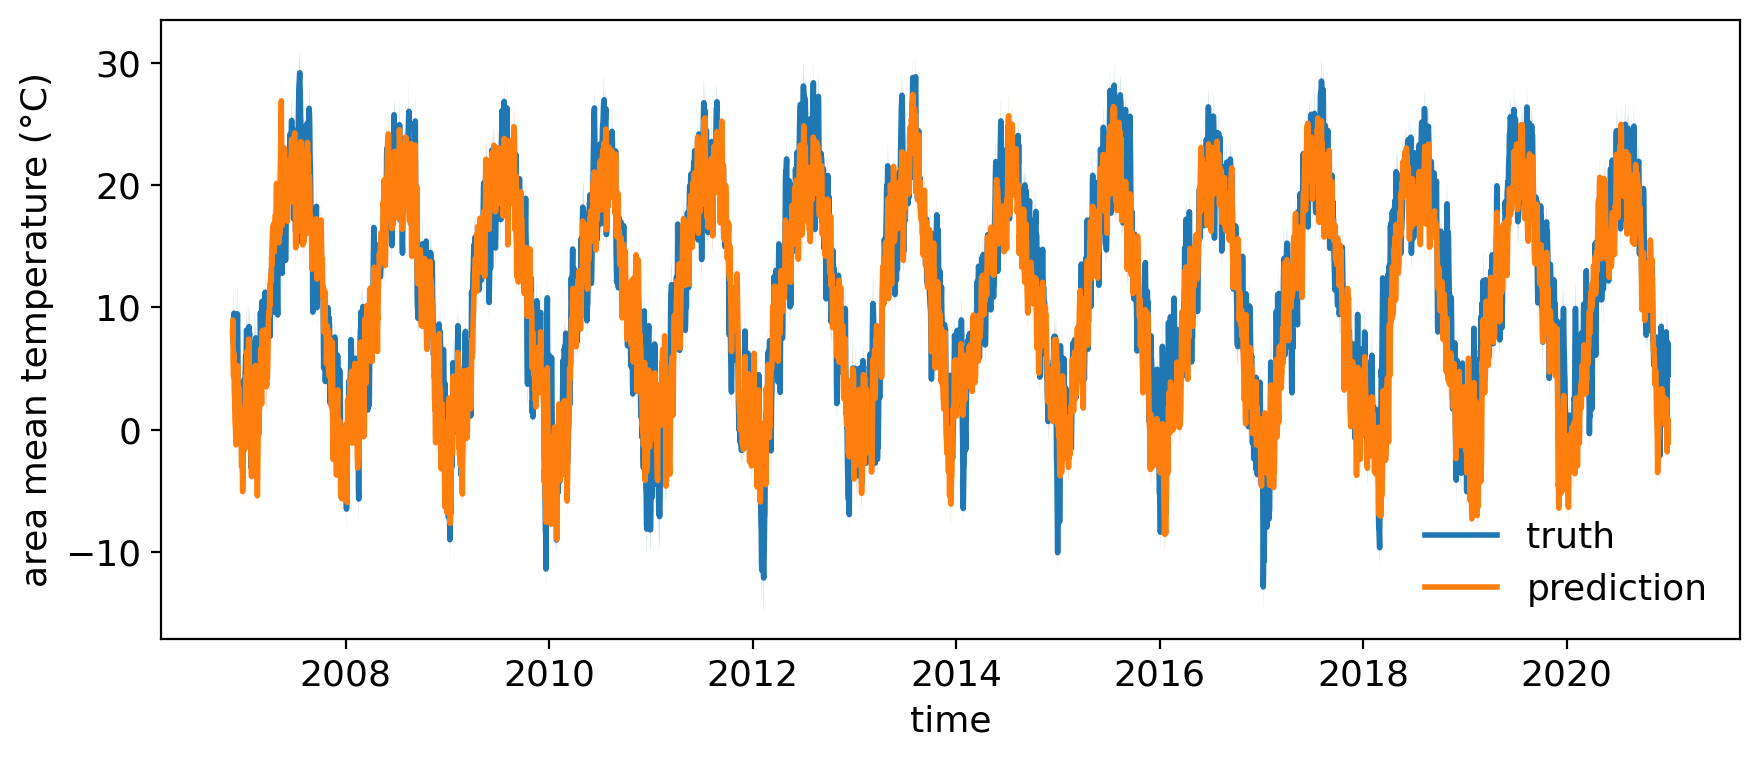

In [28]:
fig,ax = plt.subplots(figsize=(9,4))

area_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
area_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('area mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [29]:
# get area mean temperature
def area_mean(X,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X['tg'].weighted(weights).mean(['latitude', 'longitude']).data
    return tg_mean

tg_mean_xr = area_mean(y_test_xr)
tg_mean_pre = area_mean(y_test_pre)


# put into dataframe
df_area_test = pd.DataFrame()
df_area_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_area_test["truth"] = tg_mean_xr
df_area_test["prediction"] = tg_mean_pre

print(df_area_test.head(10))

# summary statistics of the dataframe
df_area_test.describe()

        time     truth  prediction
0 2006-11-21  8.020200    7.731908
1 2006-11-22  8.553507    8.971105
2 2006-11-23  7.917016    5.733365
3 2006-11-24  6.987396    4.442626
4 2006-11-25  9.470422    4.298697
5 2006-11-26  9.523687    6.246624
6 2006-11-27  7.888665    3.253402
7 2006-11-28  6.190710    2.726435
8 2006-11-29  5.319424    1.561681
9 2006-11-30  6.172898    0.648678


,time,truth,prediction
count,5155,5155.000000,5155.000000
mean,2013-12-11 00:00:00,11.294923,10.432034
min,2006-11-21 00:00:00,-12.859581,-8.954256
25%,2010-06-01 12:00:00,4.600778,3.060700
50%,2013-12-11 00:00:00,11.505891,11.207336
75%,2017-06-21 12:00:00,18.421069,17.725319
max,2020-12-31 00:00:00,29.176178,27.416222
std,NaN,8.446790,8.246955


In [30]:
rmse_bud_test_default = np.sqrt(mean_squared_error(bud_test_xr, bud_test_pre))

print(f"RMSE for Budapest: {rmse_bud_test_default}")


RMSE for Budapest: 3.418405055999756


In [31]:
rmse_test_default = np.sqrt(mean_squared_error(tg_mean_xr, tg_mean_pre))

print(f"RMSE for area: {rmse_test_default}")

RMSE for area: 3.169656143632573
